In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import datetime
from math import *
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = [16,9]

In [2]:
train_data = pd.read_csv('nyc-taxi-trip-duration/train.csv')
test_data = pd.read_csv('nyc-taxi-trip-duration/test.csv')
"""osmr_1 = pd.read_csv('new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv', 
                     usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
osmr_2 = pd.read_csv('new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv',
                     usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])"""

"osmr_1 = pd.read_csv('new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv', \n                     usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])\nosmr_2 = pd.read_csv('new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv',\n                     usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])"

We first add new features that seems to be intersting in our modelisation problem. We define a direction features based on initial and final destination using geospatial formula. 

In [3]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

jfk_coord = pd.DataFrame(np.array([[-73.778889,40.639722]]),columns=['lon','lat'])
la_guardia_coord = pd.DataFrame(np.array([[-73.872611,40.77725]]),columns=['lon','lat'])


In [4]:
train_data.loc[:, 'direction'] = bearing_array(train_data['pickup_latitude'].values, 
                                          train_data['pickup_longitude'].values, 
                                          train_data['dropoff_latitude'].values, 
                                          train_data['dropoff_longitude'].values)
train_data.loc[:, 'distance_haversine'] = haversine_array(train_data['pickup_latitude'].values, 
                                                     train_data['pickup_longitude'].values, 
                                                     train_data['dropoff_latitude'].values, 
                                                     train_data['dropoff_longitude'].values)
train_data.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(train_data['pickup_latitude'].values, 
                                                                    train_data['pickup_longitude'].values, 
                                                                    train_data['dropoff_latitude'].values, 
                                                                    train_data['dropoff_longitude'].values)

train_data['pickup_datetime'] = pd.to_datetime(train_data['pickup_datetime'])
train_data['dropoff_datetime'] = pd.to_datetime(train_data['dropoff_datetime'])
train_data['pickup_year'] = train_data['pickup_datetime'].dt.year
train_data['pickup_month'] = train_data['pickup_datetime'].dt.month
train_data['pickup_day'] = train_data['pickup_datetime'].dt.day
train_data['pickup_hour'] = train_data['pickup_datetime'].dt.hour
train_data['pickup_minute'] = train_data['pickup_datetime'].dt.minute
train_data['pickup_weekday'] = train_data['pickup_datetime'].dt.weekday

train_data['jfk_dist_pick'] = haversine_array(train_data['pickup_latitude'].values, 
                                              train_data['pickup_longitude'].values,
                                             jfk_coord['lat'].values, jfk_coord['lon'].values)
train_data['jfk_dist_drop'] = haversine_array(train_data['dropoff_latitude'].values, 
                                              train_data['dropoff_longitude'].values,
                                             jfk_coord['lat'].values, jfk_coord['lon'].values)
train_data['lg_dist_pick'] = haversine_array(train_data['pickup_latitude'].values, 
                                              train_data['pickup_longitude'].values,
                                             la_guardia_coord['lat'].values, la_guardia_coord['lon'].values)
train_data['lg_dist_drop'] = haversine_array(train_data['dropoff_latitude'].values, 
                                              train_data['dropoff_longitude'].values,
                                             la_guardia_coord['lat'].values, la_guardia_coord['lon'].values)
train_data['jfk_trip'] = (train_data['jfk_dist_pick'] < 2e3) | (train_data['jfk_dist_drop'] < 2e3)
train_data['jfk_trip'].astype(int)
train_data['lg_trip'] = (train_data['lg_dist_pick'] < 2e3) | (train_data['lg_dist_drop'] < 2e3)
train_data['lg_trip'].astype(int)
train_data['work'] = (train_data['pickup_hour'].isin(range(8,18))) & (train_data['pickup_weekday'].isin([0,1,2,3,4]))
train_data['work'].astype(int)
train_data['date'] = train_data['pickup_datetime'].dt.date

train_data['speed'] = train_data['distance_haversine']/(train_data['trip_duration']/3600)

In [5]:
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_weekday,jfk_dist_pick,jfk_dist_drop,lg_dist_pick,lg_dist_drop,jfk_trip,lg_trip,work,date,speed
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,0,22.290053,21.001874,9.282498,7.856447,True,True,True,2016-03-14,11.856428
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6,20.236314,21.197232,10.047523,11.852300,True,True,False,2016-06-12,9.803659
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,1,21.804112,20.637271,9.082822,13.445949,True,True,True,2016-01-19,10.822201
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2,21.437495,21.044602,13.213305,14.140080,True,True,False,2016-04-06,12.465721
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5,23.644565,22.794603,8.640673,8.466550,True,True,False,2016-03-26,9.836594


In [6]:
train_data.shape

(1458644, 29)

In [7]:
train_data = train_data[train_data['trip_duration'] < (22*3600)]
#isclose = isclose(train_data['distance_haversine'].values,0)
train_data = train_data[(train_data['distance_haversine']>0) | (train_data['trip_duration']<60)] 
train_data = train_data[(train_data['jfk_dist_pick'] < 3e5) & (train_data['jfk_dist_drop'] < 3e5)]
train_data = train_data[train_data['trip_duration'] > 10]
train_data = train_data[train_data['speed'] < 100]


In [8]:
weather = pd.read_csv('weather/weather_data_nyc_centralpark_2016.csv')

In [9]:
weather.head()

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,1-1-2016,42,34,38.0,0.00,0.0,0
1,2-1-2016,40,32,36.0,0.00,0.0,0
2,3-1-2016,45,35,40.0,0.00,0.0,0
3,4-1-2016,36,14,25.0,0.00,0.0,0
4,5-1-2016,29,11,20.0,0.00,0.0,0


In [10]:
weather['date'] = weather['date'].apply(lambda x : datetime.datetime.strptime(x, '%d-%m-%Y'))
def Tto(x):
    if x == 'T':
        return(0.01)
    else:
        return(x)
    
weather['rain'] = weather['precipitation'].apply(lambda x : Tto(x)).astype(float)
weather['s_fall'] = weather['snow fall'].apply(lambda x : Tto(x)).astype(float)
weather['s_depth'] = weather['snow depth'].apply(lambda x : Tto(x)).astype(float)
weather['all_precip'] = (weather['rain'].values + weather['s_fall'].values)
weather['has_snow'] = ((weather['s_fall'] > 0) | (weather['s_depth'] >0))
weather['has_rain'] = (weather['rain'] > 0) 

weather.head()

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth,rain,s_fall,s_depth,all_precip,has_snow,has_rain
0,2016-01-01,42,34,38.0,0.00,0.0,0,0.0,0.0,0.0,0.0,False,False
1,2016-01-02,40,32,36.0,0.00,0.0,0,0.0,0.0,0.0,0.0,False,False
2,2016-01-03,45,35,40.0,0.00,0.0,0,0.0,0.0,0.0,0.0,False,False
3,2016-01-04,36,14,25.0,0.00,0.0,0,0.0,0.0,0.0,0.0,False,False
4,2016-01-05,29,11,20.0,0.00,0.0,0,0.0,0.0,0.0,0.0,False,False


In [11]:
weather['date'] = pd.to_datetime(weather['date'])
train_data['date'] = pd.to_datetime(train_data['date'])

train_data = pd.merge(train_data, weather[['date','rain', 's_fall', 'all_precip', 'has_snow', 'has_rain','s_depth',
                                             'minimum temperature','maximum temperature']], on = 'date', how = 'left')




In [12]:
print(train_data.shape)


(1450265, 37)


In [13]:
osmr_1 = pd.read_csv('new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv',
                    usecols=['id', 'total_distance', 'total_travel_time','number_of_steps',
                              'step_direction', 'step_maneuvers'])
osmr_2 = pd.read_csv('new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv',
                    usecols=['id', 'total_distance', 'total_travel_time','number_of_steps',
                              'step_direction', 'step_maneuvers'])
osmr_3 = pd.read_csv('new-york-city-taxi-with-osrm/second_fastest_routes_test.csv',
                     usecols=['id', 'total_distance', 'total_travel_time','number_of_steps',
                              'step_direction', 'step_maneuvers'])

In [14]:
fastest_routes = pd.concat([osmr_1,osmr_2,osmr_3])

In [15]:
temp = fastest_routes
temp['fastest_speed'] = (temp['total_distance']/(temp['total_travel_time']+1)*3.6)
temp['left_turns'] = temp['step_direction'].str.count('left')
temp['right_turns'] = temp['step_direction'].str.count('right')
temp['turns'] = temp['step_maneuvers'].str.count('turn')
temp = temp.drop(columns=['step_direction','step_maneuvers'])
print((temp.info))

<bound method DataFrame.info of                id  total_distance  total_travel_time  number_of_steps  \
0       id2875421          2009.1              164.9                5   
1       id2377394          2513.2              332.0                6   
2       id3504673          1779.4              235.8                4   
3       id2181028          1614.9              140.1                5   
4       id0801584          1393.5              189.4                5   
...           ...             ...                ...              ...   
565860  id2790343          7015.4              726.6                6   
565861  id1901191          4720.7              457.9                9   
565862  id0664662          4499.1              410.7                8   
565863  id3008929          1141.3              166.9                6   
565864  id1384355         24120.7             1304.3               18   

        fastest_speed  left_turns  right_turns  turns  
0           43.597107           1  

In [16]:
train_data = pd.merge(train_data, temp, on = 'id', how = 'left')




In [17]:
train_data.dtypes

id                                  object
vendor_id                            int64
pickup_datetime             datetime64[ns]
dropoff_datetime            datetime64[ns]
passenger_count                      int64
pickup_longitude                   float64
pickup_latitude                    float64
dropoff_longitude                  float64
dropoff_latitude                   float64
store_and_fwd_flag                  object
trip_duration                        int64
direction                          float64
distance_haversine                 float64
distance_dummy_manhattan           float64
pickup_year                          int64
pickup_month                         int64
pickup_day                           int64
pickup_hour                          int64
pickup_minute                        int64
pickup_weekday                       int64
jfk_dist_pick                      float64
jfk_dist_drop                      float64
lg_dist_pick                       float64
lg_dist_dro

In [18]:
def blizzardTest(x):
    return(not((x.strftime('%Y-%m-%d')< '2016-01-22' ) | ( x.strftime('%Y-%m-%d') > '2016-01-29' )))

train_data['blizzard'] = train_data['date'].apply(lambda x : blizzardTest(x)).astype(int)


train_data['passenger_count'] = train_data['passenger_count'].astype(int)
train_data['vendor_id'] = train_data['vendor_id'].astype(int)
#train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].astype(int)
train_data['jfk_trip'] = train_data['jfk_trip'].astype(int)
train_data['lg_trip'] = train_data['lg_trip'].astype(int)
train_data['work'] = train_data['work'].astype(int)
train_data['has_snow'] = train_data['has_snow'].astype(int)
train_data['has_rain'] = train_data['has_rain'].astype(int)

train_data = train_data.drop(columns=['pickup_year','pickup_minute'])





In [19]:
foo1 = train_data.drop(columns=['id','pickup_datetime','dropoff_datetime','jfk_dist_pick','jfk_dist_drop',
                        'lg_dist_pick','lg_dist_drop','date'])

In [20]:
train_data.shape

(1450265, 43)

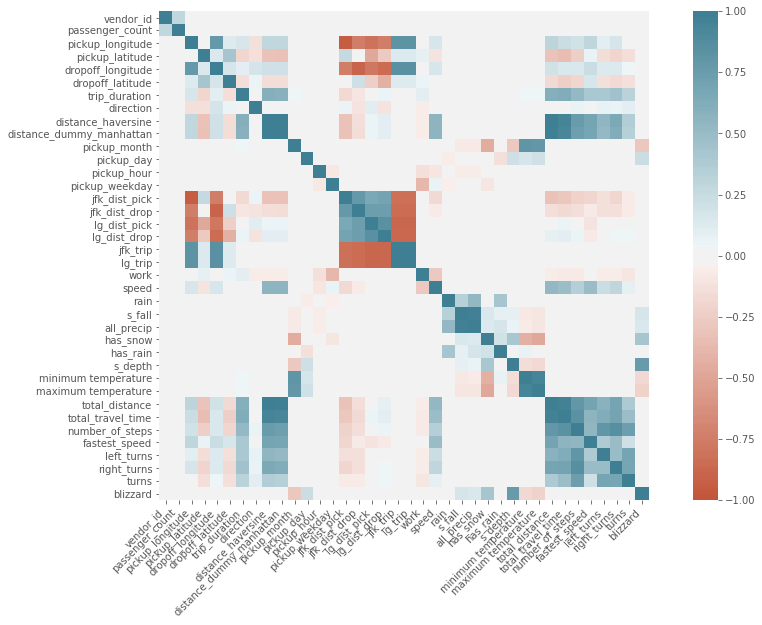

In [21]:
import seaborn as sns
corr = train_data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

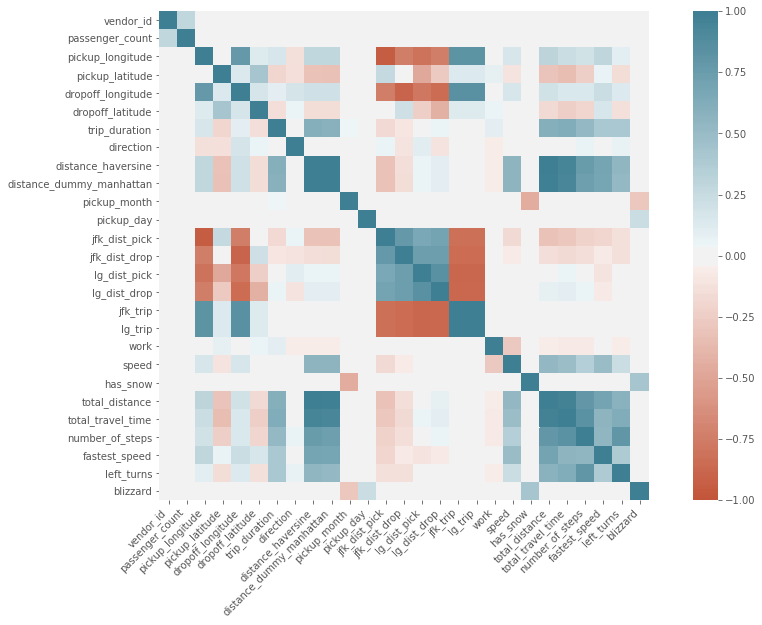

In [22]:
foo = train_data.drop(columns=['store_and_fwd_flag', 'pickup_hour', 'rain', 's_fall', 'all_precip',
         'has_rain', 's_depth', 'minimum temperature', 'maximum temperature',
         'pickup_weekday', 'right_turns', 'turns'])

corr = foo.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [23]:
data = train_data.drop(columns = ['dropoff_datetime','id','pickup_datetime',
                            'store_and_fwd_flag','date','speed'])



In [24]:
data.to_csv('preprocessed_train_data.csv')